In [1]:
import numpy as np

from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from typing import List

In [2]:
# Specify kernel with initial hyperparameter estimates
def kernel_initial(
    σf_initial=1.0,         # covariance amplitude
    ell_initial=1.0,        # length scale
    σn_initial=0.1          # noise level
):
    return σf_initial**2 * RBF(length_scale=ell_initial) + WhiteKernel(noise_level=σn_initial)

In [3]:
# Define GP's
n = 3
GPs = []
for i in range(n):
    gp = GaussianProcessRegressor(
        kernel=kernel_initial(),
        n_restarts_optimizer=10
    )
    GPs.append(gp)

In [4]:
from scipy.stats import multivariate_normal

source1 = multivariate_normal([2, 7], np.eye(2))
source2 = multivariate_normal([8, 2], 0.5*np.eye(2))

f = lambda x: source1.pdf(x) + source2.pdf(x)

x_min = (0, 0)
x_max = (10, 10)

# Define measurement noise model
σ_noise = 0.001

# Number of training points and testing points
n_train = 30

# Sample noisy observations (X1, y1) from the function for each of the GP components
for i, gp in enumerate(GPs):
    X_train = np.random.uniform(x_min, x_max, size=(n_train, 2))
    y_train = f(X_train) + np.random.normal(0, σ_noise, size=(n_train,))
    gp.fit(X_train, y_train)
    gp.fit(X_train, y_train)
    print(f"Learned kernel #{i}:\t{gp.kernel_}")
    print(type(gp.kernel_))


Learned kernel #0:	0.0606**2 * RBF(length_scale=1.52) + WhiteKernel(noise_level=1.1e-05)
<class 'sklearn.gaussian_process.kernels.Sum'>


/home/srujan/CMU/MARL_IPP_UBonn/marl_ipp/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/srujan/CMU/MARL_IPP_UBonn/marl_ipp/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Learned kernel #1:	0.0596**2 * RBF(length_scale=1.12) + WhiteKernel(noise_level=1e-05)
<class 'sklearn.gaussian_process.kernels.Sum'>


/home/srujan/CMU/MARL_IPP_UBonn/marl_ipp/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Learned kernel #2:	0.036**2 * RBF(length_scale=1.41) + WhiteKernel(noise_level=1e-05)
<class 'sklearn.gaussian_process.kernels.Sum'>


/home/srujan/CMU/MARL_IPP_UBonn/marl_ipp/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [5]:
from GP_mixture import mix_GPs


n_test = (50, 50)

# Predict points at uniform spacing to capture function
X_test_x = np.linspace(x_min[0], x_max[0], n_test[0])
X_test_y = np.linspace(x_min[1], x_max[1], n_test[1])
X_test_xx, X_test_yy = np.meshgrid(X_test_x, X_test_y)
X_test = np.vstack(np.dstack((X_test_xx, X_test_yy)))


# Compute posterior mean and covariance of GP mixture model
GP_mixture_model = mix_GPs(GPs)
μ_test, σ_test = GP_mixture_model(X_test)


0.274**2 * RBF(length_scale=9.8) + WhiteKernel(noise_level=0.218)


/home/srujan/CMU/MARL_IPP_UBonn/marl_ipp/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0.33**2 * RBF(length_scale=1e+05) + WhiteKernel(noise_level=0.225)
0.384**2 * RBF(length_scale=21.3) + WhiteKernel(noise_level=0.218)


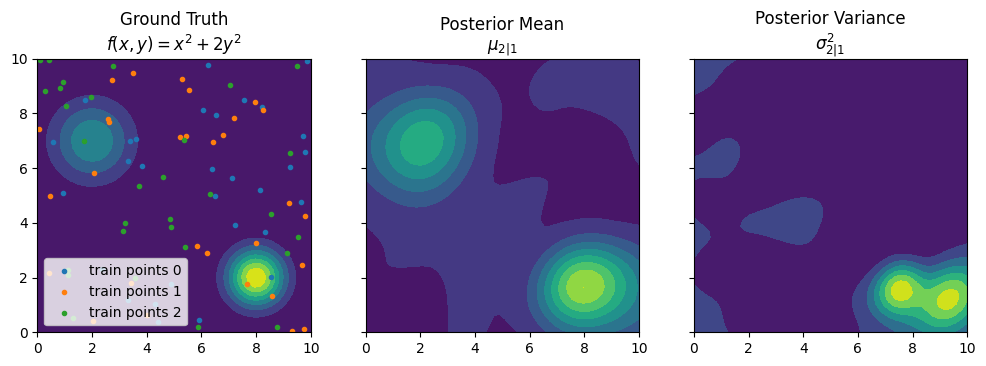

In [6]:
# Visualize
μ_test_2D = μ_test.reshape(n_test)
σ_test_2D = σ_test.reshape(n_test)

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
ax[0].set_aspect("equal", "box")
ax[1].set_aspect("equal", "box")
ax[2].set_aspect("equal", "box")

ax[0].set_title("Ground Truth\n$f(x, y) = x^2 + 2y^2$")
ax[0].contourf(X_test_xx, X_test_yy, f(X_test).reshape(n_test))

for i, gp in enumerate(GPs):
    ax[0].scatter(*gp.X_train_.T, marker=".", label=f"train points {i}")

ax[0].legend(loc="lower left")

ax[1].set_title("Posterior Mean\n$\mu_{2|1}$")
ax[1].contourf(X_test_xx, X_test_yy, μ_test_2D)

ax[2].set_title("Posterior Variance\n$\sigma^2_{2|1}$")
ax[2].contourf(X_test_xx, X_test_yy, σ_test_2D)